In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from itertools import product

In [2]:
df_train = pd.read_csv("./archive/train.csv")
df_test = pd.read_csv("./archive/test.csv")

In [3]:
df_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [4]:
df_test.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"


In [5]:
# Data preprocessing 
def preprocess_stock_data(data, window_size=60, scaler=None, is_train=True):
    data['Date'] = pd.to_datetime(data['Date'])
    data = data.sort_values('Date').reset_index(drop=True)
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        data[col] = data[col].replace(',', '', regex=True).astype(float)
    numerical_features = ['Open', 'High', 'Low', 'Close', 'Volume']
    if scaler is None:  # Fit scaler only on training data
        scaler = MinMaxScaler(feature_range=(0, 1))
        data[numerical_features] = scaler.fit_transform(data[numerical_features])
    else:
        data[numerical_features] = scaler.transform(data[numerical_features])
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data.loc[i-window_size:i-1, numerical_features].values)
        y.append(data.loc[i, 'Close'])
    X = np.array(X)
    y = np.array(y)
    if is_train:
        return X, y, scaler
    else:
        return X, y


In [6]:
# Combine training and testing dataset
combined_df = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)

# Preprocess the combined dataset
window_size = 60
X_combined, y_combined, scaler = preprocess_stock_data(combined_df, window_size=window_size, is_train=True)

# Splitting dataset into 60-20-20 (training, validation, testing) 
dataset_size = len(X_combined)
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size) 

# Split data sequentially
X_train, y_train = X_combined[:train_size], y_combined[:train_size]
X_val, y_val = X_combined[train_size:train_size+val_size], y_combined[train_size:train_size+val_size]
X_test, y_test = X_combined[train_size+val_size:], y_combined[train_size+val_size:]

# Print sizes for verification
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# Data is now split into appropriate ratio

Training set: (730, 60, 5), (730,)
Validation set: (243, 60, 5), (243,)
Test set: (245, 60, 5), (245,)


In [7]:
# Defining a class and using dataloader to 'batch' data for better suitability with model
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32).unsqueeze(-1)

# Create datasets
train_dataset = StockDataset(X_train, y_train)
val_dataset = StockDataset(X_val, y_val)
test_dataset = StockDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [8]:
# Define the Vanilla RNN model
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out


In [9]:
# Training the Vanilla RNN

# Hyperparameters
input_size = X_train.shape[2]
hidden_size = 50
output_size = 1 
num_layers = 1
num_epochs = 50
learning_rate = 0.001
device = torch.device("mps" if torch.cuda.is_available() else "cpu")
model = VanillaRNN(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)



In [10]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}")


Epoch [1/50], Train Loss: 0.1002, Validation Loss: 0.0651
Epoch [2/50], Train Loss: 0.0746, Validation Loss: 0.0138
Epoch [3/50], Train Loss: 0.0449, Validation Loss: 0.0178
Epoch [4/50], Train Loss: 0.0260, Validation Loss: 0.0046
Epoch [5/50], Train Loss: 0.0250, Validation Loss: 0.0112
Epoch [6/50], Train Loss: 0.0104, Validation Loss: 0.0012
Epoch [7/50], Train Loss: 0.0158, Validation Loss: 0.0142
Epoch [8/50], Train Loss: 0.0081, Validation Loss: 0.0040
Epoch [9/50], Train Loss: 0.0071, Validation Loss: 0.0008
Epoch [10/50], Train Loss: 0.0105, Validation Loss: 0.0089
Epoch [11/50], Train Loss: 0.0051, Validation Loss: 0.0027
Epoch [12/50], Train Loss: 0.0056, Validation Loss: 0.0009
Epoch [13/50], Train Loss: 0.0077, Validation Loss: 0.0052
Epoch [14/50], Train Loss: 0.0040, Validation Loss: 0.0021
Epoch [15/50], Train Loss: 0.0050, Validation Loss: 0.0008
Epoch [16/50], Train Loss: 0.0061, Validation Loss: 0.0033
Epoch [17/50], Train Loss: 0.0038, Validation Loss: 0.0019
Epoch 

In [11]:
# Evaluation on Test Set
# Test the model
model.eval()
test_loss = 0.0
predictions, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()

        predictions.append(outputs.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

# Flatten predictions and actuals for comparison
predictions = np.concatenate(predictions).flatten()
actuals = np.concatenate(actuals).flatten()

print(f"Test Loss: {test_loss/len(test_loader):.4f}")


Test Loss: 0.0002


In [12]:
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-Squared: {r2}")


Mean Squared Error (MSE): 0.0002259401953779161
Mean Absolute Error (MAE): 0.011451463215053082
R-Squared: 0.9126322854250477


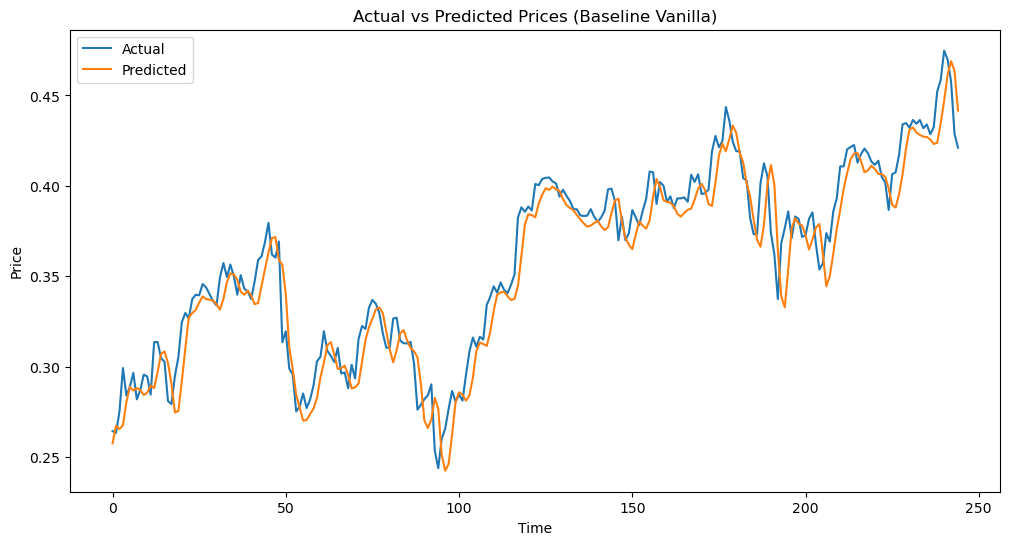

In [13]:
# Baseline Plot 

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.title("Actual vs Predicted Prices (Baseline Vanilla)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()


In [14]:
# Define hyperparameter grid
hidden_sizes = [50, 100, 200]
num_layers_list = [1, 2]
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [16, 32, 64]
hyperparameter_grid = list(product(hidden_sizes, num_layers_list, learning_rates, batch_sizes))
results = []

for hidden_size, num_layers, learning_rate, batch_size in hyperparameter_grid:
    print(f"Training with hidden_size={hidden_size}, num_layers={num_layers}, learning_rate={learning_rate}, batch_size={batch_size}")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = VanillaRNN(input_size, hidden_size, output_size, num_layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    for epoch in range(10):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
        print(f"Epoch [{epoch+1}/10], Train Loss: {train_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}")

    results.append({
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'val_loss': val_loss / len(val_loader)
    })
results = sorted(results, key=lambda x: x['val_loss'])
print("Best Configuration:", results[0])

Training with hidden_size=50, num_layers=1, learning_rate=0.01, batch_size=16
Epoch [1/10], Train Loss: 0.0162, Validation Loss: 0.0012
Epoch [2/10], Train Loss: 0.0022, Validation Loss: 0.0003
Epoch [3/10], Train Loss: 0.0017, Validation Loss: 0.0005
Epoch [4/10], Train Loss: 0.0015, Validation Loss: 0.0015
Epoch [5/10], Train Loss: 0.0015, Validation Loss: 0.0005
Epoch [6/10], Train Loss: 0.0015, Validation Loss: 0.0005
Epoch [7/10], Train Loss: 0.0015, Validation Loss: 0.0056
Epoch [8/10], Train Loss: 0.0017, Validation Loss: 0.0004
Epoch [9/10], Train Loss: 0.0014, Validation Loss: 0.0004
Epoch [10/10], Train Loss: 0.0015, Validation Loss: 0.0006
Training with hidden_size=50, num_layers=1, learning_rate=0.01, batch_size=32
Epoch [1/10], Train Loss: 0.0189, Validation Loss: 0.0023
Epoch [2/10], Train Loss: 0.0030, Validation Loss: 0.0034
Epoch [3/10], Train Loss: 0.0018, Validation Loss: 0.0003
Epoch [4/10], Train Loss: 0.0016, Validation Loss: 0.0010
Epoch [5/10], Train Loss: 0.001

Epoch [6/10], Train Loss: 0.0020, Validation Loss: 0.0005
Epoch [7/10], Train Loss: 0.0019, Validation Loss: 0.0007
Epoch [8/10], Train Loss: 0.0019, Validation Loss: 0.0010
Epoch [9/10], Train Loss: 0.0017, Validation Loss: 0.0004
Epoch [10/10], Train Loss: 0.0019, Validation Loss: 0.0013
Training with hidden_size=50, num_layers=2, learning_rate=0.001, batch_size=32
Epoch [1/10], Train Loss: 0.1216, Validation Loss: 0.0092
Epoch [2/10], Train Loss: 0.0432, Validation Loss: 0.0047
Epoch [3/10], Train Loss: 0.0054, Validation Loss: 0.0037
Epoch [4/10], Train Loss: 0.0029, Validation Loss: 0.0007
Epoch [5/10], Train Loss: 0.0026, Validation Loss: 0.0007
Epoch [6/10], Train Loss: 0.0025, Validation Loss: 0.0009
Epoch [7/10], Train Loss: 0.0023, Validation Loss: 0.0008
Epoch [8/10], Train Loss: 0.0021, Validation Loss: 0.0009
Epoch [9/10], Train Loss: 0.0021, Validation Loss: 0.0005
Epoch [10/10], Train Loss: 0.0020, Validation Loss: 0.0005
Training with hidden_size=50, num_layers=2, learn

Epoch [2/10], Train Loss: 0.0815, Validation Loss: 0.0385
Epoch [3/10], Train Loss: 0.0587, Validation Loss: 0.0459
Epoch [4/10], Train Loss: 0.0506, Validation Loss: 0.0403
Epoch [5/10], Train Loss: 0.0422, Validation Loss: 0.0370
Epoch [6/10], Train Loss: 0.0317, Validation Loss: 0.0297
Epoch [7/10], Train Loss: 0.0174, Validation Loss: 0.0109
Epoch [8/10], Train Loss: 0.0058, Validation Loss: 0.0023
Epoch [9/10], Train Loss: 0.0045, Validation Loss: 0.0012
Epoch [10/10], Train Loss: 0.0042, Validation Loss: 0.0013
Training with hidden_size=100, num_layers=1, learning_rate=0.0001, batch_size=64
Epoch [1/10], Train Loss: 0.2025, Validation Loss: 0.0380
Epoch [2/10], Train Loss: 0.1322, Validation Loss: 0.0111
Epoch [3/10], Train Loss: 0.0826, Validation Loss: 0.0134
Epoch [4/10], Train Loss: 0.0565, Validation Loss: 0.0376
Epoch [5/10], Train Loss: 0.0503, Validation Loss: 0.0453
Epoch [6/10], Train Loss: 0.0472, Validation Loss: 0.0352
Epoch [7/10], Train Loss: 0.0439, Validation Los

Epoch [8/10], Train Loss: 0.0875, Validation Loss: 0.0629
Epoch [9/10], Train Loss: 0.0784, Validation Loss: 0.0604
Epoch [10/10], Train Loss: 0.0749, Validation Loss: 0.1062
Training with hidden_size=200, num_layers=1, learning_rate=0.01, batch_size=64
Epoch [1/10], Train Loss: 1.2447, Validation Loss: 3.0401
Epoch [2/10], Train Loss: 1.1176, Validation Loss: 1.2609
Epoch [3/10], Train Loss: 0.3898, Validation Loss: 0.4808
Epoch [4/10], Train Loss: 0.1716, Validation Loss: 0.2134
Epoch [5/10], Train Loss: 0.1026, Validation Loss: 0.1151
Epoch [6/10], Train Loss: 0.0847, Validation Loss: 0.0640
Epoch [7/10], Train Loss: 0.0807, Validation Loss: 0.0241
Epoch [8/10], Train Loss: 0.0780, Validation Loss: 0.0382
Epoch [9/10], Train Loss: 0.0739, Validation Loss: 0.0150
Epoch [10/10], Train Loss: 0.0774, Validation Loss: 0.0237
Training with hidden_size=200, num_layers=1, learning_rate=0.001, batch_size=16
Epoch [1/10], Train Loss: 0.0263, Validation Loss: 0.0011
Epoch [2/10], Train Loss: 0

Epoch [2/10], Train Loss: 0.0115, Validation Loss: 0.0013
Epoch [3/10], Train Loss: 0.0056, Validation Loss: 0.0005
Epoch [4/10], Train Loss: 0.0029, Validation Loss: 0.0026
Epoch [5/10], Train Loss: 0.0024, Validation Loss: 0.0017
Epoch [6/10], Train Loss: 0.0022, Validation Loss: 0.0006
Epoch [7/10], Train Loss: 0.0019, Validation Loss: 0.0005
Epoch [8/10], Train Loss: 0.0019, Validation Loss: 0.0008
Epoch [9/10], Train Loss: 0.0018, Validation Loss: 0.0004
Epoch [10/10], Train Loss: 0.0016, Validation Loss: 0.0005
Training with hidden_size=200, num_layers=2, learning_rate=0.0001, batch_size=16
Epoch [1/10], Train Loss: 0.0659, Validation Loss: 0.0111
Epoch [2/10], Train Loss: 0.0083, Validation Loss: 0.0051
Epoch [3/10], Train Loss: 0.0040, Validation Loss: 0.0017
Epoch [4/10], Train Loss: 0.0037, Validation Loss: 0.0010
Epoch [5/10], Train Loss: 0.0034, Validation Loss: 0.0010
Epoch [6/10], Train Loss: 0.0032, Validation Loss: 0.0009
Epoch [7/10], Train Loss: 0.0028, Validation Los

In [15]:
# Define the final Vanilla RNN model with the best configuration
final_model = VanillaRNN(input_size, hidden_size=200, output_size=1, num_layers=2).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(final_model.parameters(), lr=0.001)
final_train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
final_val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

num_epochs = 50
for epoch in range(num_epochs):
    final_model.train()
    train_loss = 0.0
    for X_batch, y_batch in final_train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = final_model(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    final_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in final_val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = final_model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(final_train_loader):.4f}, Validation Loss: {val_loss/len(final_val_loader):.4f}")

Epoch [1/50], Train Loss: 0.0255, Validation Loss: 0.0040
Epoch [2/50], Train Loss: 0.0023, Validation Loss: 0.0009
Epoch [3/50], Train Loss: 0.0024, Validation Loss: 0.0013
Epoch [4/50], Train Loss: 0.0024, Validation Loss: 0.0004
Epoch [5/50], Train Loss: 0.0019, Validation Loss: 0.0004
Epoch [6/50], Train Loss: 0.0020, Validation Loss: 0.0007
Epoch [7/50], Train Loss: 0.0018, Validation Loss: 0.0017
Epoch [8/50], Train Loss: 0.0030, Validation Loss: 0.0014
Epoch [9/50], Train Loss: 0.0016, Validation Loss: 0.0003
Epoch [10/50], Train Loss: 0.0013, Validation Loss: 0.0005
Epoch [11/50], Train Loss: 0.0012, Validation Loss: 0.0005
Epoch [12/50], Train Loss: 0.0016, Validation Loss: 0.0004
Epoch [13/50], Train Loss: 0.0013, Validation Loss: 0.0005
Epoch [14/50], Train Loss: 0.0017, Validation Loss: 0.0010
Epoch [15/50], Train Loss: 0.0016, Validation Loss: 0.0022
Epoch [16/50], Train Loss: 0.0021, Validation Loss: 0.0006
Epoch [17/50], Train Loss: 0.0013, Validation Loss: 0.0004
Epoch 

In [16]:
final_model.eval()
test_loss = 0.0
predictions, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = final_model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()
        predictions.append(outputs.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())
predictions = np.concatenate(predictions).flatten()
actuals = np.concatenate(actuals).flatten()

Test Loss: 0.0003


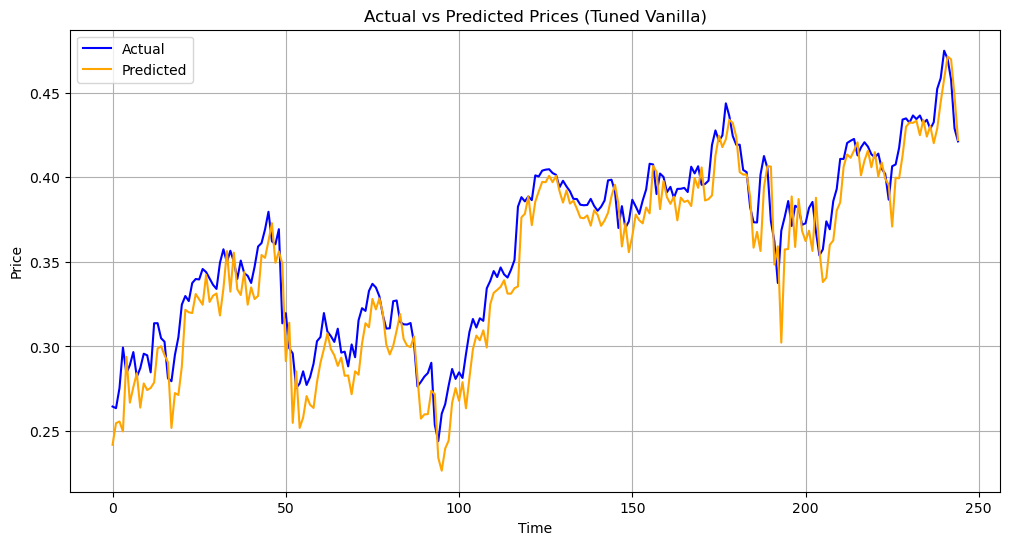

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(actuals, label="Actual", color="blue")
plt.plot(predictions, label="Predicted", color="orange")
plt.title("Actual vs Predicted Prices (Tuned Vanilla)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [18]:
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-Squared: {r2}")


Mean Squared Error (MSE): 0.0003009033971466124
Mean Absolute Error (MAE): 0.013826078735291958
R-Squared: 0.8836451312674188


In [19]:
# LSTM v2
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0)) 
        out = self.fc(out[:, -1, :])
        return out

# Default hyperparameters
input_size = X_train.shape[2]  
hidden_size = 50               
output_size = 1                
num_layers = 1                
dropout = 0.2                 
learning_rate = 0.001          
num_epochs = 50                

model = LSTMModel(input_size, hidden_size, output_size, num_layers, dropout).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}")


Epoch [1/50], Train Loss: 0.0831, Validation Loss: 0.0513


/Users/edwardquah/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch [2/50], Train Loss: 0.0579, Validation Loss: 0.0567
Epoch [3/50], Train Loss: 0.0405, Validation Loss: 0.0250
Epoch [4/50], Train Loss: 0.0182, Validation Loss: 0.0053
Epoch [5/50], Train Loss: 0.0107, Validation Loss: 0.0096
Epoch [6/50], Train Loss: 0.0067, Validation Loss: 0.0124
Epoch [7/50], Train Loss: 0.0056, Validation Loss: 0.0048
Epoch [8/50], Train Loss: 0.0048, Validation Loss: 0.0045
Epoch [9/50], Train Loss: 0.0042, Validation Loss: 0.0029
Epoch [10/50], Train Loss: 0.0040, Validation Loss: 0.0016
Epoch [11/50], Train Loss: 0.0036, Validation Loss: 0.0016
Epoch [12/50], Train Loss: 0.0035, Validation Loss: 0.0010
Epoch [13/50], Train Loss: 0.0030, Validation Loss: 0.0011
Epoch [14/50], Train Loss: 0.0030, Validation Loss: 0.0008
Epoch [15/50], Train Loss: 0.0027, Validation Loss: 0.0011
Epoch [16/50], Train Loss: 0.0027, Validation Loss: 0.0008
Epoch [17/50], Train Loss: 0.0027, Validation Loss: 0.0011
Epoch [18/50], Train Loss: 0.0027, Validation Loss: 0.0008
Epoch

In [20]:
# Evaluate on the test set
model.eval()
test_loss = 0.0
predictions, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()
        predictions.append(outputs.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())
predictions = np.concatenate(predictions).flatten()
actuals = np.concatenate(actuals).flatten()

print(f"Test Loss (MSE): {test_loss/len(test_loader):.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-Squared: {r2:.4f}")

Test Loss (MSE): 0.0004
Mean Absolute Error (MAE): 0.0138
R-Squared: 0.8836


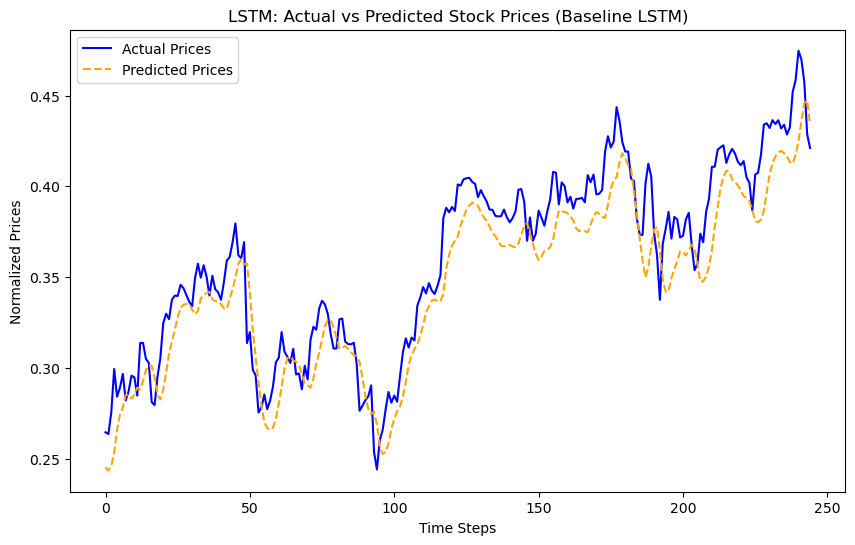

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual Prices', color='blue')
plt.plot(predictions, label='Predicted Prices', color='orange', linestyle='--')
plt.title('LSTM: Actual vs Predicted Stock Prices (Baseline LSTM)')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Prices')
plt.legend()
plt.show()


In [22]:
# Tuning LSTM
# Define hyperparameter grid
hidden_sizes = [50, 100, 200]
num_layers_list = [1, 2, 3]   
dropout_rates = [0.2, 0.3, 0.5]  
learning_rates = [0.001, 0.0001]  
batch_sizes = [16, 32, 64]    

# Create combinations of hyperparameters
hyperparameter_grid = list(product(hidden_sizes, num_layers_list, dropout_rates, learning_rates, batch_sizes))


In [23]:
# Initialize results storage
results = []
for hidden_size, num_layers, dropout, learning_rate, batch_size in hyperparameter_grid:
    print(f"Training with hidden_size={hidden_size}, num_layers={num_layers}, dropout={dropout}, learning_rate={learning_rate}, batch_size={batch_size}")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    model = LSTMModel(input_size, hidden_size, output_size, num_layers, dropout).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    num_epochs = 10 
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f"Validation Loss: {val_loss:.4f}")

    results.append({
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'dropout': dropout,
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'val_loss': val_loss
    })
results = sorted(results, key=lambda x: x['val_loss'])
print("Best Configuration:", results[0])

Training with hidden_size=50, num_layers=1, dropout=0.2, learning_rate=0.001, batch_size=16
Validation Loss: 0.0026
Training with hidden_size=50, num_layers=1, dropout=0.2, learning_rate=0.001, batch_size=32
Validation Loss: 0.0044
Training with hidden_size=50, num_layers=1, dropout=0.2, learning_rate=0.001, batch_size=64
Validation Loss: 0.0052
Training with hidden_size=50, num_layers=1, dropout=0.2, learning_rate=0.0001, batch_size=16
Validation Loss: 0.0057
Training with hidden_size=50, num_layers=1, dropout=0.2, learning_rate=0.0001, batch_size=32
Validation Loss: 0.0582
Training with hidden_size=50, num_layers=1, dropout=0.2, learning_rate=0.0001, batch_size=64
Validation Loss: 0.0283
Training with hidden_size=50, num_layers=1, dropout=0.3, learning_rate=0.001, batch_size=16


/Users/edwardquah/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Validation Loss: 0.0030
Training with hidden_size=50, num_layers=1, dropout=0.3, learning_rate=0.001, batch_size=32
Validation Loss: 0.0041
Training with hidden_size=50, num_layers=1, dropout=0.3, learning_rate=0.001, batch_size=64
Validation Loss: 0.0146
Training with hidden_size=50, num_layers=1, dropout=0.3, learning_rate=0.0001, batch_size=16
Validation Loss: 0.0035
Training with hidden_size=50, num_layers=1, dropout=0.3, learning_rate=0.0001, batch_size=32
Validation Loss: 0.0524
Training with hidden_size=50, num_layers=1, dropout=0.3, learning_rate=0.0001, batch_size=64
Validation Loss: 0.0084
Training with hidden_size=50, num_layers=1, dropout=0.5, learning_rate=0.001, batch_size=16


/Users/edwardquah/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Validation Loss: 0.0008
Training with hidden_size=50, num_layers=1, dropout=0.5, learning_rate=0.001, batch_size=32
Validation Loss: 0.0042
Training with hidden_size=50, num_layers=1, dropout=0.5, learning_rate=0.001, batch_size=64
Validation Loss: 0.0118
Training with hidden_size=50, num_layers=1, dropout=0.5, learning_rate=0.0001, batch_size=16
Validation Loss: 0.0039
Training with hidden_size=50, num_layers=1, dropout=0.5, learning_rate=0.0001, batch_size=32
Validation Loss: 0.0414
Training with hidden_size=50, num_layers=1, dropout=0.5, learning_rate=0.0001, batch_size=64
Validation Loss: 0.0280
Training with hidden_size=50, num_layers=2, dropout=0.2, learning_rate=0.001, batch_size=16
Validation Loss: 0.0012
Training with hidden_size=50, num_layers=2, dropout=0.2, learning_rate=0.001, batch_size=32
Validation Loss: 0.0015
Training with hidden_size=50, num_layers=2, dropout=0.2, learning_rate=0.001, batch_size=64
Validation Loss: 0.0041
Training with hidden_size=50, num_layers=2, d

Validation Loss: 0.0332
Training with hidden_size=100, num_layers=2, dropout=0.5, learning_rate=0.001, batch_size=16
Validation Loss: 0.0024
Training with hidden_size=100, num_layers=2, dropout=0.5, learning_rate=0.001, batch_size=32
Validation Loss: 0.0052
Training with hidden_size=100, num_layers=2, dropout=0.5, learning_rate=0.001, batch_size=64
Validation Loss: 0.0077
Training with hidden_size=100, num_layers=2, dropout=0.5, learning_rate=0.0001, batch_size=16
Validation Loss: 0.0118
Training with hidden_size=100, num_layers=2, dropout=0.5, learning_rate=0.0001, batch_size=32
Validation Loss: 0.0065
Training with hidden_size=100, num_layers=2, dropout=0.5, learning_rate=0.0001, batch_size=64
Validation Loss: 0.0358
Training with hidden_size=100, num_layers=3, dropout=0.2, learning_rate=0.001, batch_size=16
Validation Loss: 0.0038
Training with hidden_size=100, num_layers=3, dropout=0.2, learning_rate=0.001, batch_size=32
Validation Loss: 0.0031
Training with hidden_size=100, num_la

Validation Loss: 0.0072
Training with hidden_size=200, num_layers=3, dropout=0.3, learning_rate=0.0001, batch_size=32
Validation Loss: 0.0149
Training with hidden_size=200, num_layers=3, dropout=0.3, learning_rate=0.0001, batch_size=64
Validation Loss: 0.0073
Training with hidden_size=200, num_layers=3, dropout=0.5, learning_rate=0.001, batch_size=16
Validation Loss: 0.0011
Training with hidden_size=200, num_layers=3, dropout=0.5, learning_rate=0.001, batch_size=32
Validation Loss: 0.0011
Training with hidden_size=200, num_layers=3, dropout=0.5, learning_rate=0.001, batch_size=64
Validation Loss: 0.0012
Training with hidden_size=200, num_layers=3, dropout=0.5, learning_rate=0.0001, batch_size=16
Validation Loss: 0.0048
Training with hidden_size=200, num_layers=3, dropout=0.5, learning_rate=0.0001, batch_size=32
Validation Loss: 0.0102
Training with hidden_size=200, num_layers=3, dropout=0.5, learning_rate=0.0001, batch_size=64
Validation Loss: 0.0062
Best Configuration: {'hidden_size':

In [24]:
# Best hyperparameters from grid search
best_config = results[0]
hidden_size = best_config['hidden_size']
num_layers = best_config['num_layers']
dropout = best_config['dropout']
learning_rate = best_config['learning_rate']
batch_size = best_config['batch_size']
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = LSTMModel(input_size, hidden_size, output_size, num_layers, dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}")

Epoch [1/50], Train Loss: 0.0682, Validation Loss: 0.0071
Epoch [2/50], Train Loss: 0.0278, Validation Loss: 0.0036
Epoch [3/50], Train Loss: 0.0053, Validation Loss: 0.0057
Epoch [4/50], Train Loss: 0.0041, Validation Loss: 0.0027
Epoch [5/50], Train Loss: 0.0033, Validation Loss: 0.0019
Epoch [6/50], Train Loss: 0.0032, Validation Loss: 0.0011
Epoch [7/50], Train Loss: 0.0027, Validation Loss: 0.0013
Epoch [8/50], Train Loss: 0.0027, Validation Loss: 0.0008
Epoch [9/50], Train Loss: 0.0027, Validation Loss: 0.0008
Epoch [10/50], Train Loss: 0.0027, Validation Loss: 0.0015
Epoch [11/50], Train Loss: 0.0025, Validation Loss: 0.0021
Epoch [12/50], Train Loss: 0.0028, Validation Loss: 0.0009
Epoch [13/50], Train Loss: 0.0025, Validation Loss: 0.0009
Epoch [14/50], Train Loss: 0.0021, Validation Loss: 0.0007
Epoch [15/50], Train Loss: 0.0024, Validation Loss: 0.0011
Epoch [16/50], Train Loss: 0.0023, Validation Loss: 0.0006
Epoch [17/50], Train Loss: 0.0022, Validation Loss: 0.0007
Epoch 

Mean Squared Error (MSE): 0.00020819911151193082
Mean Absolute Error (MAE): 0.010640962049365044
R-Squared: 0.919492501771985


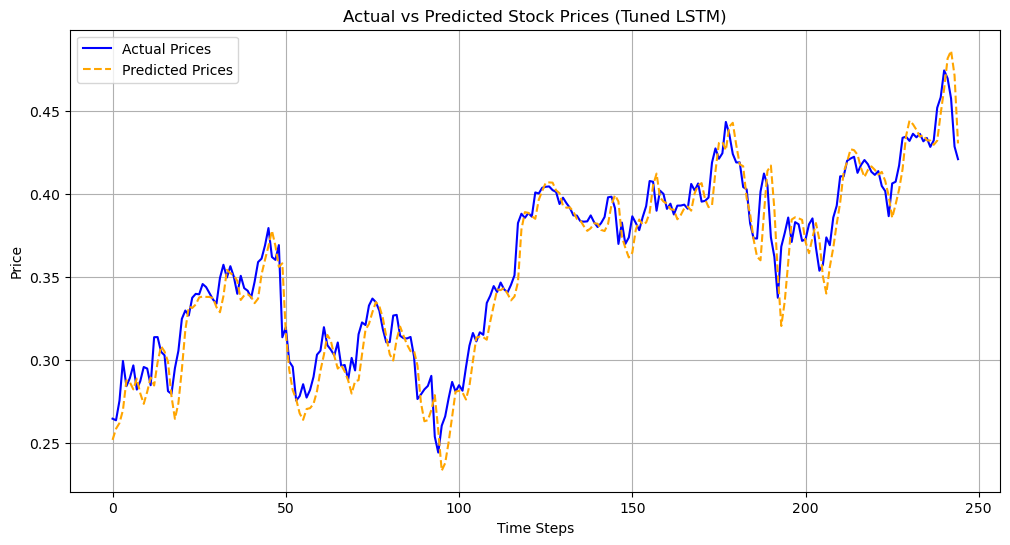

In [25]:
# Evaluate on the test set
model.eval()
test_loss = 0.0
predictions, actuals = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()
        predictions.append(outputs.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

predictions = np.concatenate(predictions).flatten()
actuals = np.concatenate(actuals).flatten()

# Metrics
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-Squared: {r2}")

plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual Prices', color='blue')
plt.plot(predictions, label='Predicted Prices', color='orange', linestyle='--')
plt.title('Actual vs Predicted Stock Prices (Tuned LSTM)')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [41]:
# GRU v2
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out


In [42]:
# Hyperparameters
input_size = X_train.shape[2]
hidden_size = 50
output_size = 1
num_layers = 1
dropout = 0.2
learning_rate = 0.001
num_epochs = 50     
model = GRUModel(input_size, hidden_size, output_size, num_layers, dropout).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


/Users/edwardquah/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [43]:
# Training baseline GRU
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}")


Epoch [1/50], Train Loss: 0.0669, Validation Loss: 0.0210
Epoch [2/50], Train Loss: 0.0096, Validation Loss: 0.0017
Epoch [3/50], Train Loss: 0.0027, Validation Loss: 0.0022
Epoch [4/50], Train Loss: 0.0029, Validation Loss: 0.0011
Epoch [5/50], Train Loss: 0.0025, Validation Loss: 0.0005
Epoch [6/50], Train Loss: 0.0021, Validation Loss: 0.0008
Epoch [7/50], Train Loss: 0.0022, Validation Loss: 0.0005
Epoch [8/50], Train Loss: 0.0019, Validation Loss: 0.0004
Epoch [9/50], Train Loss: 0.0020, Validation Loss: 0.0005
Epoch [10/50], Train Loss: 0.0018, Validation Loss: 0.0005
Epoch [11/50], Train Loss: 0.0020, Validation Loss: 0.0005
Epoch [12/50], Train Loss: 0.0018, Validation Loss: 0.0005
Epoch [13/50], Train Loss: 0.0019, Validation Loss: 0.0009
Epoch [14/50], Train Loss: 0.0016, Validation Loss: 0.0006
Epoch [15/50], Train Loss: 0.0016, Validation Loss: 0.0004
Epoch [16/50], Train Loss: 0.0016, Validation Loss: 0.0004
Epoch [17/50], Train Loss: 0.0016, Validation Loss: 0.0005
Epoch 

In [44]:
# Evaluate on the test set
model.eval()
test_loss = 0.0
predictions, actuals = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()

        predictions.append(outputs.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())


predictions = np.concatenate(predictions).flatten()
actuals = np.concatenate(actuals).flatten()
mse = test_loss / len(test_loader)
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)
print(f"Test Loss (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-Squared: {r2:.4f}")


Test Loss (MSE): 0.0010
Mean Absolute Error (MAE): 0.0298
R-Squared: 0.6106


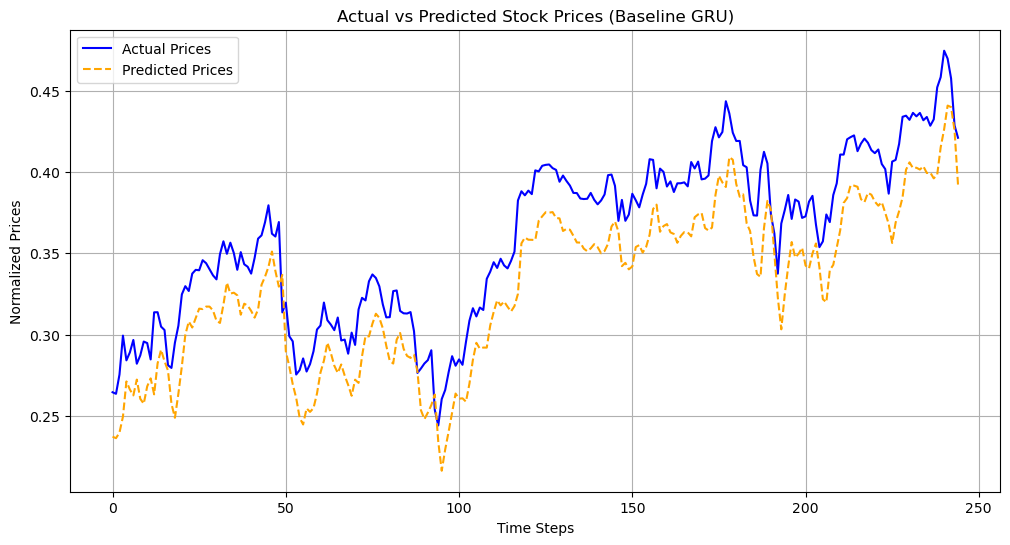

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual Prices', color='blue')
plt.plot(predictions, label='Predicted Prices', color='orange', linestyle='--')
plt.title('Actual vs Predicted Stock Prices (Baseline GRU)')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Prices')
plt.legend()
plt.grid()
plt.show()

In [46]:
hidden_sizes = [50, 100, 200]
num_layers_list = [1, 2, 3]
dropout_rates = [0.2, 0.3, 0.5]
learning_rates = [0.001, 0.0005, 0.0001]
batch_sizes = [16, 32, 64]
hyperparameter_grid = list(product(hidden_sizes, num_layers_list, dropout_rates, learning_rates, batch_sizes))


In [47]:
# Initialize results storage
results = []

for hidden_size, num_layers, dropout, learning_rate, batch_size in hyperparameter_grid:
    print(f"Training with hidden_size={hidden_size}, num_layers={num_layers}, dropout={dropout}, learning_rate={learning_rate}, batch_size={batch_size}")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    model = GRUModel(input_size, hidden_size, output_size, num_layers, dropout).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f"Validation Loss: {val_loss:.4f}")

    # Store results
    results.append({
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'dropout': dropout,
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'val_loss': val_loss
    })

# Sort results by validation loss
results = sorted(results, key=lambda x: x['val_loss'])
print("Best Configuration:", results[0])


Training with hidden_size=50, num_layers=1, dropout=0.2, learning_rate=0.001, batch_size=16


/Users/edwardquah/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Validation Loss: 0.0007
Training with hidden_size=50, num_layers=1, dropout=0.2, learning_rate=0.001, batch_size=32
Validation Loss: 0.0008
Training with hidden_size=50, num_layers=1, dropout=0.2, learning_rate=0.001, batch_size=64
Validation Loss: 0.0008
Training with hidden_size=50, num_layers=1, dropout=0.2, learning_rate=0.0005, batch_size=16
Validation Loss: 0.0016
Training with hidden_size=50, num_layers=1, dropout=0.2, learning_rate=0.0005, batch_size=32
Validation Loss: 0.0008
Training with hidden_size=50, num_layers=1, dropout=0.2, learning_rate=0.0005, batch_size=64
Validation Loss: 0.0057
Training with hidden_size=50, num_layers=1, dropout=0.2, learning_rate=0.0001, batch_size=16
Validation Loss: 0.0164
Training with hidden_size=50, num_layers=1, dropout=0.2, learning_rate=0.0001, batch_size=32
Validation Loss: 0.0368
Training with hidden_size=50, num_layers=1, dropout=0.2, learning_rate=0.0001, batch_size=64
Validation Loss: 0.0175
Training with hidden_size=50, num_layers=1

/Users/edwardquah/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Validation Loss: 0.0004
Training with hidden_size=50, num_layers=1, dropout=0.3, learning_rate=0.001, batch_size=32
Validation Loss: 0.0020
Training with hidden_size=50, num_layers=1, dropout=0.3, learning_rate=0.001, batch_size=64
Validation Loss: 0.0006
Training with hidden_size=50, num_layers=1, dropout=0.3, learning_rate=0.0005, batch_size=16
Validation Loss: 0.0013
Training with hidden_size=50, num_layers=1, dropout=0.3, learning_rate=0.0005, batch_size=32
Validation Loss: 0.0008
Training with hidden_size=50, num_layers=1, dropout=0.3, learning_rate=0.0005, batch_size=64
Validation Loss: 0.0228
Training with hidden_size=50, num_layers=1, dropout=0.3, learning_rate=0.0001, batch_size=16
Validation Loss: 0.0161
Training with hidden_size=50, num_layers=1, dropout=0.3, learning_rate=0.0001, batch_size=32
Validation Loss: 0.0313
Training with hidden_size=50, num_layers=1, dropout=0.3, learning_rate=0.0001, batch_size=64
Validation Loss: 0.0199
Training with hidden_size=50, num_layers=1

/Users/edwardquah/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Validation Loss: 0.0005
Training with hidden_size=50, num_layers=1, dropout=0.5, learning_rate=0.001, batch_size=32
Validation Loss: 0.0006
Training with hidden_size=50, num_layers=1, dropout=0.5, learning_rate=0.001, batch_size=64
Validation Loss: 0.0015
Training with hidden_size=50, num_layers=1, dropout=0.5, learning_rate=0.0005, batch_size=16
Validation Loss: 0.0006
Training with hidden_size=50, num_layers=1, dropout=0.5, learning_rate=0.0005, batch_size=32
Validation Loss: 0.0026
Training with hidden_size=50, num_layers=1, dropout=0.5, learning_rate=0.0005, batch_size=64
Validation Loss: 0.0014
Training with hidden_size=50, num_layers=1, dropout=0.5, learning_rate=0.0001, batch_size=16
Validation Loss: 0.0021
Training with hidden_size=50, num_layers=1, dropout=0.5, learning_rate=0.0001, batch_size=32
Validation Loss: 0.0288
Training with hidden_size=50, num_layers=1, dropout=0.5, learning_rate=0.0001, batch_size=64
Validation Loss: 0.0299
Training with hidden_size=50, num_layers=2

Validation Loss: 0.0383
Training with hidden_size=100, num_layers=1, dropout=0.3, learning_rate=0.001, batch_size=16
Validation Loss: 0.0010
Training with hidden_size=100, num_layers=1, dropout=0.3, learning_rate=0.001, batch_size=32
Validation Loss: 0.0006
Training with hidden_size=100, num_layers=1, dropout=0.3, learning_rate=0.001, batch_size=64
Validation Loss: 0.0008
Training with hidden_size=100, num_layers=1, dropout=0.3, learning_rate=0.0005, batch_size=16
Validation Loss: 0.0006
Training with hidden_size=100, num_layers=1, dropout=0.3, learning_rate=0.0005, batch_size=32
Validation Loss: 0.0006
Training with hidden_size=100, num_layers=1, dropout=0.3, learning_rate=0.0005, batch_size=64
Validation Loss: 0.0010
Training with hidden_size=100, num_layers=1, dropout=0.3, learning_rate=0.0001, batch_size=16
Validation Loss: 0.0016
Training with hidden_size=100, num_layers=1, dropout=0.3, learning_rate=0.0001, batch_size=32
Validation Loss: 0.0018
Training with hidden_size=100, num_

Validation Loss: 0.0020
Training with hidden_size=100, num_layers=3, dropout=0.5, learning_rate=0.0001, batch_size=32
Validation Loss: 0.0015
Training with hidden_size=100, num_layers=3, dropout=0.5, learning_rate=0.0001, batch_size=64
Validation Loss: 0.0039
Training with hidden_size=200, num_layers=1, dropout=0.2, learning_rate=0.001, batch_size=16
Validation Loss: 0.0007
Training with hidden_size=200, num_layers=1, dropout=0.2, learning_rate=0.001, batch_size=32
Validation Loss: 0.0005
Training with hidden_size=200, num_layers=1, dropout=0.2, learning_rate=0.001, batch_size=64
Validation Loss: 0.0006
Training with hidden_size=200, num_layers=1, dropout=0.2, learning_rate=0.0005, batch_size=16
Validation Loss: 0.0021
Training with hidden_size=200, num_layers=1, dropout=0.2, learning_rate=0.0005, batch_size=32
Validation Loss: 0.0010
Training with hidden_size=200, num_layers=1, dropout=0.2, learning_rate=0.0005, batch_size=64
Validation Loss: 0.0008
Training with hidden_size=200, num_

Validation Loss: 0.0009
Training with hidden_size=200, num_layers=3, dropout=0.3, learning_rate=0.0005, batch_size=64
Validation Loss: 0.0013
Training with hidden_size=200, num_layers=3, dropout=0.3, learning_rate=0.0001, batch_size=16
Validation Loss: 0.0013
Training with hidden_size=200, num_layers=3, dropout=0.3, learning_rate=0.0001, batch_size=32
Validation Loss: 0.0023
Training with hidden_size=200, num_layers=3, dropout=0.3, learning_rate=0.0001, batch_size=64
Validation Loss: 0.0013
Training with hidden_size=200, num_layers=3, dropout=0.5, learning_rate=0.001, batch_size=16
Validation Loss: 0.0006
Training with hidden_size=200, num_layers=3, dropout=0.5, learning_rate=0.001, batch_size=32
Validation Loss: 0.0006
Training with hidden_size=200, num_layers=3, dropout=0.5, learning_rate=0.001, batch_size=64
Validation Loss: 0.0010
Training with hidden_size=200, num_layers=3, dropout=0.5, learning_rate=0.0005, batch_size=16
Validation Loss: 0.0034
Training with hidden_size=200, num_

In [48]:
# Best hyperparameters from grid search
best_config = results[0]
hidden_size = best_config['hidden_size']
num_layers = best_config['num_layers']
dropout = best_config['dropout']
learning_rate = best_config['learning_rate']
batch_size = best_config['batch_size']

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = GRUModel(input_size, hidden_size, output_size, num_layers, dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}")

Epoch [1/50], Train Loss: 0.0302, Validation Loss: 0.0030
Epoch [2/50], Train Loss: 0.0035, Validation Loss: 0.0015
Epoch [3/50], Train Loss: 0.0034, Validation Loss: 0.0010
Epoch [4/50], Train Loss: 0.0026, Validation Loss: 0.0006
Epoch [5/50], Train Loss: 0.0025, Validation Loss: 0.0005
Epoch [6/50], Train Loss: 0.0025, Validation Loss: 0.0008
Epoch [7/50], Train Loss: 0.0028, Validation Loss: 0.0011
Epoch [8/50], Train Loss: 0.0026, Validation Loss: 0.0005
Epoch [9/50], Train Loss: 0.0020, Validation Loss: 0.0004
Epoch [10/50], Train Loss: 0.0027, Validation Loss: 0.0010
Epoch [11/50], Train Loss: 0.0022, Validation Loss: 0.0005
Epoch [12/50], Train Loss: 0.0023, Validation Loss: 0.0009
Epoch [13/50], Train Loss: 0.0021, Validation Loss: 0.0009
Epoch [14/50], Train Loss: 0.0021, Validation Loss: 0.0004
Epoch [15/50], Train Loss: 0.0018, Validation Loss: 0.0004
Epoch [16/50], Train Loss: 0.0018, Validation Loss: 0.0004
Epoch [17/50], Train Loss: 0.0022, Validation Loss: 0.0013
Epoch 

In [49]:
# Test evaluation
model.eval()
test_loss = 0.0
predictions, actuals = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()
        predictions.append(outputs.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

predictions = np.concatenate(predictions).flatten()
actuals = np.concatenate(actuals).flatten()

# Metrics
mse = test_loss / len(test_loader)
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f"Test Loss (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-Squared: {r2:.4f}")


Test Loss (MSE): 0.0002
Mean Absolute Error (MAE): 0.0114
R-Squared: 0.9228


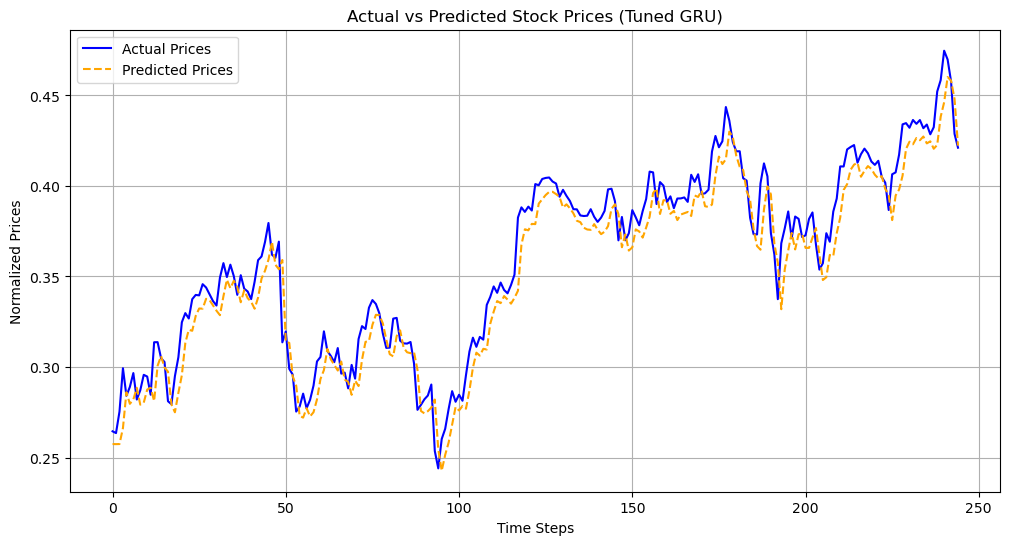

In [50]:
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual Prices', color='blue')
plt.plot(predictions, label='Predicted Prices', color='orange', linestyle='--')
plt.title('Actual vs Predicted Stock Prices (Tuned GRU)')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Prices')
plt.legend()
plt.grid()
plt.show()

In [51]:
# Metrics
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-Squared: {r2}")


Mean Squared Error (MSE): 0.00019959472410846502
Mean Absolute Error (MAE): 0.011388924904167652
R-Squared: 0.9228196875362469


In [52]:
# Final run model performances 
# BASE Vanilla
# Mean Squared Error (MSE): 0.0002259401953779161
# Mean Absolute Error (MAE): 0.011451463215053082
# R-Squared: 0.9126322854250477

# TUNEDVanilla
# Mean Squared Error (MSE): 0.0003009033971466124
# Mean Absolute Error (MAE): 0.013826078735291958
# R-Squared: 0.8836451312674188

# BASE LSTM
# Test Loss (MSE): 0.0004
# Mean Absolute Error (MAE): 0.0138
# R-Squared: 0.8836

# TUNED LSTM
# Mean Squared Error (MSE): 0.00020819911151193082
# Mean Absolute Error (MAE): 0.010640962049365044
# R-Squared: 0.919492501771985


# BASE GRU
# Test Loss (MSE): 0.0003
# Mean Absolute Error (MAE): 0.0152
# R-Squared: 0.8723

# TUNED GRU
# Mean Squared Error (MSE): 0.000438192073488608
# Mean Absolute Error (MAE): 0.018680592998862267
# R-Squared: 0.8305576512823637